# Week8
## Overview

It's the last time we meet in class for exercises! And to celebrate this mile-stone, I've put together an very nice little set of exercises. And if you're behind, don't worry. The workload is low!

  - Part A: First, we play around with sentiment analysis
  - That's it!


# Part A: Sentiment analysis

Sentiment analysis is another highly useful technique which we'll use to make sense of the Wiki
data. Further, experience shows that it might well be very useful when you get to the project stage of the class.



> **Video Lecture**: Uncle Sune talks about sentiment and his own youthful adventures.



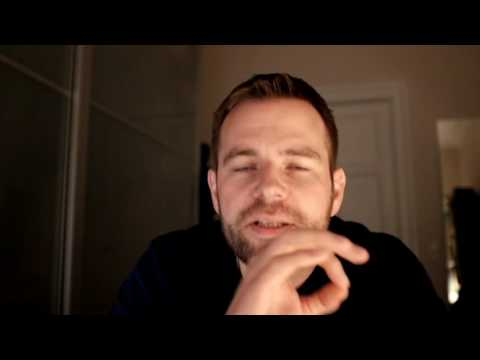

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo("JuYcaYYlfrI",width=800, height=450)

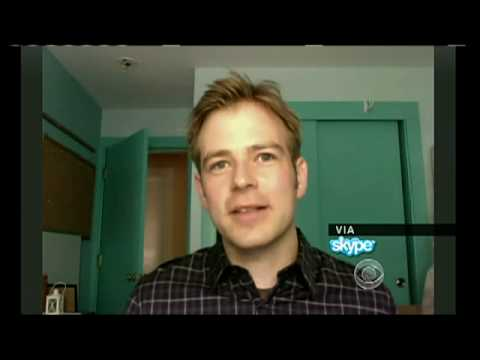

In [2]:
# There's also this one from 2010 with young Sune's research
YouTubeVideo("hY0UCD5UiiY",width=800, height=450)

> Reading: [Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752) 


*Exercise*: Sentiment distribution. 
> 
> * Download the LabMT wordlist. It's available as supplementary material from [Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752) (Data Set S1). Describe briefly how the list was generated.
> * Based on the LabMT word list, write a function that calculates sentiment given a list of tokens (the tokens should be lower case, etc).
> * Iterage over the nodes in your network, tokenize each page, and calculate sentiment every single page. Now you have sentiment as a new nodal property.
> * Calculate the average sentiment across all the pages. Also calculate the median, variance, 25th percentile, 75th percentile.
> * Remember histograms? Create a histogram of all of the artists's associated page-sentiments. (And make it a nice histogram - use your histogram making skills from Week 2). Add the mean, meadian, ect from above to your plot.
> * Who are the 10 artists with happiest and saddest pages?


*Exercise*: Community sentiment distribution. 
  
> * Last week we calculated the stuctural communities of the graph. For this exercise, we use those communities (just the 10 largest ones). Specifically, you should calculate the average the average sentiment of the nodes in each community to find a *community level sentiment*. 
>   - Name each community by its three most connected bands. (Or feed the list of bands in each community and ask the LLM to come up with a good name for the community).
>   - What are the three happiest communities? 
>   - what are the three saddest communities?
>   - Do these results confirm what you can learn about each community by comparing to the genres, checking out the word-clouds for each community, and reading the wiki-pages? 
> * Compare the sentiment of the happiest and saddest communities to the overall (entire network) distribution of sentiment that you calculated in the previous exercise. Are the communities very differenct from the average? Or do you find the sentiment to be quite similar across all of the communities?

**Note**: Calculating sentiment may take a long time, so arm yourself with patience as your code runs (remember to check that it runs correctly, before waiting patiently). Further, these tips may speed things up. And save somewhere, so you don't have to start over.

**Tips for speed**
* If you use `freqDist` prior to finding the sentiment, you only have to find it for every unique word and hereafter you can do a weighted mean.
* More tips for speeding up loops https://wiki.python.org/moin/PythonSpeed/PerformanceTips#Loops

Loaded H: 483 nodes, 7587 edges, directed=True
LabMT loaded: 10,222 word scores.

Computed sentiment for 361 pages (out of 483 nodes).
Missing page files for 122 artists (skipped). First few: ['Icehouse_(band)', 'The_Mamas_&_the_Papas', 'X_(American_band)', 'Flyleaf_(band)', 'Faces_(band)', 'Blur_(band)', "Manfred_Mann's_Earth_Band", 'Bill_Haley_&_His_Comets', 'Interpol_(band)', 'Tesla_(band)']

Summary statistics on page sentiments (LabMT, stop_window=1.0):
     mean: 6.264
   median: 6.279
  variance: 0.019
      p25: 6.210
      p75: 6.347
    count: 361


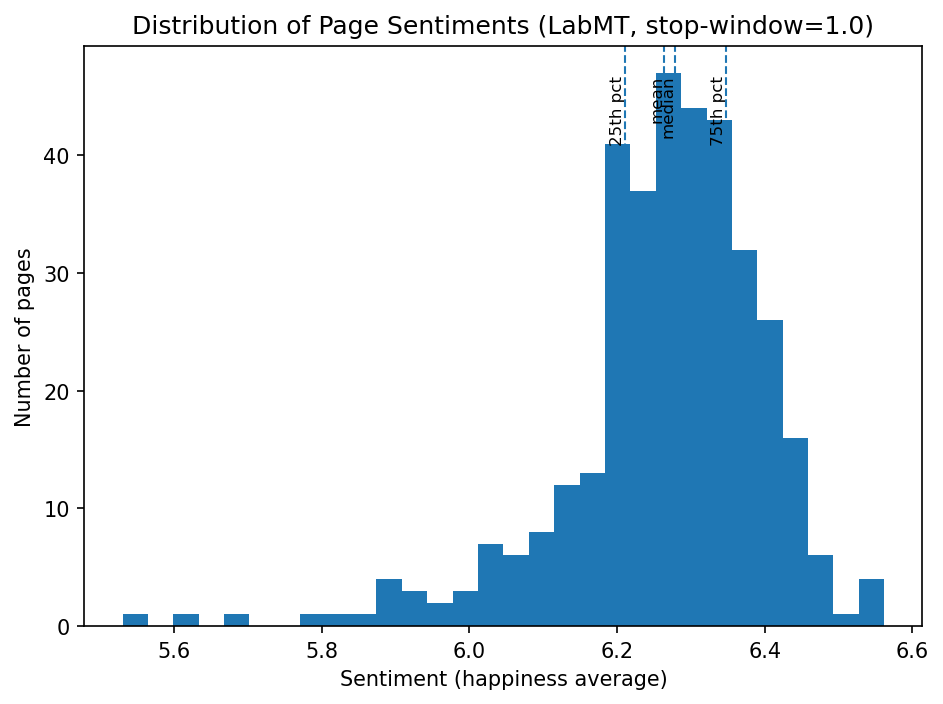


=== Saddest 10 pages (lowest sentiment) ===
                  artist  sentiment_labmt  n_tokens_used                    page_file
 Five_Finger_Death_Punch         5.530230           4267  Five_Finger_Death_Punch.txt
              Rob_Zombie         5.600982           5592               Rob_Zombie.txt
Rage_Against_the_Machine         5.680208           5239 Rage_Against_the_Machine.txt
                No_Doubt         5.804595           2888                 No_Doubt.txt
           Drowning_Pool         5.833103           1405            Drowning_Pool.txt
             Bad_Company         5.853534           1415              Bad_Company.txt
         Third_Eye_Blind         5.876638           3230          Third_Eye_Blind.txt
       Breaking_Benjamin         5.889494           3931        Breaking_Benjamin.txt
              Quiet_Riot         5.897583           2474               Quiet_Riot.txt
          Marilyn_Manson         5.901148           7745           Marilyn_Manson.txt

=== Happ

In [17]:
import os
import re
import math
import pickle
from typing import List, Dict, Tuple, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- 0) Helpers & configuration ----------

GRAPH_PATHS = [
    "rock_performers_LWCC.gpickle",
]

LABMT_PATHS = [
    "../files/Data_Set_S1.txt",
]

PAGES_DIR_CANDIDATES = [
    "pages",                 # default relative folder a student may hav            # some users keep the artist files directly here
]

STOP_WINDOW = 1.0  # LabMT standard: drop words with 4.0 <= score <= 6.0 (i.e., |score - 5| < 1.0)
HIST_FNAME = "sentiment_hist.png"
CSV_FNAME = "page_sentiments.csv"


def locate_first_existing(paths: List[str]) -> Optional[str]:
    for p in paths:
        if os.path.exists(p):
            return p
    return None


def safe_filename(name: str) -> str:
    """
    Map a node/artist name to a plausible filename, e.g. "AC/DC" -> "AC_DC.txt".
    We'll try a few variants (.txt appended if needed).
    """
    base = name.strip()
    # common replacements seen in scraped titles
    base = base.replace("/", "_").replace(" ", "_")
    # remove characters that commonly trip filesystems
    base = re.sub(r'[^A-Za-z0-9_\-\.]', '', base)
    # ensure .txt extension
    if not base.lower().endswith(".txt"):
        base = base + ".txt"
    return base


def find_page_for_artist(artist: str, page_dirs: List[str]) -> Optional[str]:
    candidate = safe_filename(artist)
    # try each pages dir
    for d in page_dirs:
        if not os.path.isdir(d):
            continue
        p = os.path.join(d, candidate)
        if os.path.exists(p):
            return p
    # also try directly in each directory candidate (in case d was a file path like /mnt/data)
    for d in page_dirs:
        p = os.path.join(d, candidate)
        if os.path.exists(p):
            return p
    # no luck
    return None


def load_text(path: str) -> str:
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        return f.read()


def simple_tokenize(text: str) -> List[str]:
    # Lowercase, then keep alphabetic words (allowing internal apostrophes).
    return re.findall(r"[a-z][a-z']+", text.lower())


# ---------- 1) Load network ----------

graph_path = locate_first_existing(GRAPH_PATHS)
if graph_path is None:
    raise FileNotFoundError("Missing rock_performers_LWCC.gpickle. "
                            "Re-open Week 4 and run the 'Save for Week 5' cell.")

with open(graph_path, "rb") as f:
    H = pickle.load(f)

print(f"Loaded H: {H.number_of_nodes()} nodes, {H.number_of_edges()} edges, directed={H.is_directed()}")


# ---------- 2) Load LabMT, build lexicon ----------

labmt_path = locate_first_existing(LABMT_PATHS)
if labmt_path is None:
    raise FileNotFoundError("Missing Data_Set_S1.txt (LabMT list). Please place it in /mnt/data/.")

# The LabMT text file includes a short header followed by a tab-separated table.
# We'll auto-detect the header row that begins with "word<TAB>happiness_rank..."
header_idx = None
with open(labmt_path, "r", encoding="utf-8", errors="ignore") as f:
    lines = f.readlines()
for i, line in enumerate(lines):
    if line.lower().startswith("word\thappiness_rank"):
        header_idx = i
        break
if header_idx is None:
    raise ValueError("Could not find LabMT header line in Data_Set_S1.txt.")

labmt_df = pd.read_csv(labmt_path, sep="\t", skiprows=header_idx, encoding="utf-8")
# Keep only required columns and drop NaNs
labmt_df = labmt_df[["word", "happiness_average"]].dropna()
labmt_df["word"] = labmt_df["word"].astype(str).str.lower()

# Build dictionary: word -> score
labmt_scores: Dict[str, float] = dict(zip(labmt_df["word"].values, labmt_df["happiness_average"].values))

print(f"LabMT loaded: {len(labmt_scores):,} word scores.")


# ---------- 3) Sentiment function (LabMT-style with stop-window) ----------

def labmt_sentiment(tokens: List[str], scores: Dict[str, float], stop_window: float = 1.0) -> Tuple[float, int]:
    """
    Compute LabMT sentiment as the average happiness score of tokens whose
    score lies outside [5 - stop_window, 5 + stop_window].

    Returns:
        (sentiment_value, n_used)
        If no tokens pass the stop-window filter, returns (np.nan, 0).
    """
    used_scores = []
    low, high = 5.0 - stop_window, 5.0 + stop_window
    for t in tokens:
        sc = scores.get(t)
        if sc is None:
            continue
        if (sc <= low) or (sc >= high):
            used_scores.append(sc)
    if not used_scores:
        return (float("nan"), 0)
    return (float(np.mean(used_scores)), len(used_scores))


# ---------- 4) Iterate nodes, load pages, compute sentiment ----------

page_dirs = [d for d in PAGES_DIR_CANDIDATES if os.path.exists(d)]
if not page_dirs:
    # Ensure at least /mnt/data is checked; students often place files there
    page_dirs = ["/mnt/data"]

sentiments = []
missing_pages = []

for node in H.nodes():
    path = find_page_for_artist(str(node), page_dirs)
    if path is None:
        missing_pages.append(str(node))
        H.nodes[node]["sentiment_labmt"] = float("nan")
        H.nodes[node]["sentiment_token_count"] = 0
        continue

    text = load_text(path)
    tokens = simple_tokenize(text)
    s, n_used = labmt_sentiment(tokens, labmt_scores, stop_window=STOP_WINDOW)
    H.nodes[node]["sentiment_labmt"] = s
    H.nodes[node]["sentiment_token_count"] = n_used
    sentiments.append((str(node), s, n_used, os.path.basename(path)))

sent_df = pd.DataFrame(sentiments, columns=["artist", "sentiment_labmt", "n_tokens_used", "page_file"])
sent_df = sent_df.sort_values("artist").reset_index(drop=True)

# Save per-page sentiments
sent_df.to_csv(CSV_FNAME, index=False)

print(f"\nComputed sentiment for {sent_df['sentiment_labmt'].notna().sum()} pages "
      f"(out of {H.number_of_nodes()} nodes).")
if missing_pages:
    print(f"Missing page files for {len(missing_pages)} artists (skipped). "
          f"First few: {missing_pages[:10]}")


# ---------- 5) Summary statistics ----------

valid = sent_df["sentiment_labmt"].dropna().values
summary_stats = {}
if valid.size > 0:
    summary_stats = {
        "mean": float(np.mean(valid)),
        "median": float(np.median(valid)),
        "variance": float(np.var(valid, ddof=1)) if valid.size > 1 else float("nan"),
        "p25": float(np.percentile(valid, 25)),
        "p75": float(np.percentile(valid, 75)),
        "count": int(valid.size),
    }

print("\nSummary statistics on page sentiments (LabMT, stop_window=1.0):")
for k, v in summary_stats.items():
    if isinstance(v, float):
        print(f"  {k:>7}: {v:.3f}")
    else:
        print(f"  {k:>7}: {v}")


# ---------- 6) Plot: Histogram of page sentiments ----------

if valid.size > 0:
    plt.figure(dpi=150)
    plt.hist(valid, bins=30)
    plt.title("Distribution of Page Sentiments (LabMT, stop-window=1.0)")
    plt.xlabel("Sentiment (happiness average)")
    plt.ylabel("Number of pages")

    # Add vertical lines with labels for mean, median, quartiles
    mean_v = summary_stats["mean"]
    med_v = summary_stats["median"]
    p25_v = summary_stats["p25"]
    p75_v = summary_stats["p75"]

    for x, label in [(mean_v, "mean"), (med_v, "median"), (p25_v, "25th pct"), (p75_v, "75th pct")]:
        plt.axvline(x, linestyle="--", linewidth=1)
        # annotate slightly above the top of the plot using axes coords
        ylim = plt.gca().get_ylim()
        plt.text(x, ylim[1]*0.95, label, rotation=90, va="top", ha="right", fontsize=8)

    plt.tight_layout()
    plt.savefig(HIST_FNAME)
    plt.show()

else:
    print("No valid sentiments to plot (all pages missing or no scored tokens).")


# ---------- 7) Top-10 happiest and saddest pages ----------

ranked = sent_df.dropna(subset=["sentiment_labmt"]).sort_values("sentiment_labmt")
saddest_10 = ranked.head(10).copy()
happiest_10 = ranked.tail(10).iloc[::-1].copy()

# Show the top/bottom sentiment tables neatly
print("\n=== Saddest 10 pages (lowest sentiment) ===")
print(saddest_10.to_string(index=False))

print("\n=== Happiest 10 pages (highest sentiment) ===")
print(happiest_10.to_string(index=False))

print("\nFiles written:")
print(f" - Sentiments CSV: {CSV_FNAME}")
print(f" - Histogram PNG:  {HIST_FNAME}")

# Also show a small sample of the per-page table
print("\nSample of per-page sentiments:")
print(sent_df.head(12))

In [18]:
# --- Recreate structural communities from Week 7 ---

import pickle, networkx as nx
from collections import Counter
from networkx.algorithms.community.louvain import louvain_communities

# Load your network (with sentiment already stored)
with open("rock_performers_LWCC.gpickle", "rb") as f:
    H = pickle.load(f)
H = H.to_undirected()

# Load your artist→genres mapping (for consistency)
with open("artist_genres.pickle", "rb") as f:
    artist_genres = pickle.load(f)

# Keep only nodes that exist both in graph and genre list
nodes_with_genre = [n for n in H.nodes if n in artist_genres]
G = H.subgraph(nodes_with_genre).copy()

print(f"Filtered graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# Compute Louvain communities (same as in Week 7)
communities = louvain_communities(G, seed=42, resolution=1.0)
community_of = {}
for cid, com in enumerate(communities):
    for n in com:
        community_of[n] = cid

print(f"Detected {len(communities)} communities using Louvain algorithm.")

# (Optional) Save for future reuse, so you don’t recompute next time:
with open("community_labels.pickle", "wb") as f:
    pickle.dump({"community_of": community_of, "communities": communities}, f)
print("Saved community labels to community_labels.pickle")

Filtered graph: 482 nodes, 5943 edges
Detected 6 communities using Louvain algorithm.
Saved community labels to community_labels.pickle


In [19]:
print(len(H), len(community_of))
# Should be roughly similar (within missing nodes)
print(next(iter(H.nodes(data=True))))  # Should include 'sentiment_labmt'

483 482
('The_White_Stripes', {'content_length': 28385})


In [22]:
import pickle, pandas as pd, numpy as np, networkx as nx
from collections import defaultdict

# --- Step 1: Load your network and community data ---
with open("rock_performers_LWCC.gpickle", "rb") as f:
    H = pickle.load(f)

# Load community labels from your saved pickle (Week 7)
with open("community_labels.pickle", "rb") as f:
    data = pickle.load(f)
community_of = data["community_of"]
communities = data["communities"]

print(f"Loaded graph: {H.number_of_nodes()} nodes")
print(f"Loaded {len(communities)} Louvain communities.")

# --- Step 2: Reattach sentiments from CSV ---
sent_df = pd.read_csv("page_sentiments.csv")

# Normalize node names to handle underscores/spaces inconsistencies
def normalize_name(name):
    return name.replace("_", " ").strip().lower()

# Build lookup map for sentiment
sent_map = {normalize_name(r["artist"]): r["sentiment_labmt"] for _, r in sent_df.iterrows()}

# Assign sentiment back to nodes
added = 0
for node in H.nodes():
    key = normalize_name(str(node))
    if key in sent_map:
        H.nodes[node]["sentiment_labmt"] = sent_map[key]
        added += 1

print(f"Reattached sentiment to {added} nodes.")

# --- Step 3: Verify overlap now ---
sentiment_nodes = {n for n, d in H.nodes(data=True)
                   if "sentiment_labmt" in d and not np.isnan(d["sentiment_labmt"])}
community_nodes = set(community_of.keys())
print(f"Nodes with sentiment: {len(sentiment_nodes)}")
print(f"Nodes with community label: {len(community_nodes)}")
print(f"Overlap after fix: {len(sentiment_nodes & community_nodes)} shared nodes")


Loaded graph: 483 nodes
Loaded 6 Louvain communities.
Reattached sentiment to 361 nodes.
Nodes with sentiment: 361
Nodes with community label: 482
Overlap after fix: 360 shared nodes


In [25]:
import pandas as pd, numpy as np

# Load the sentiment CSV generated earlier
sent_df = pd.read_csv("page_sentiments.csv")

# Normalize node names to improve matching
def normalize_name(name):
    return name.replace("_", " ").strip().lower()

sent_map = {normalize_name(r["artist"]): r["sentiment_labmt"] for _, r in sent_df.iterrows()}

# Assign back to H
attached = 0
for node in H.nodes():
    key = normalize_name(str(node))
    if key in sent_map:
        H.nodes[node]["sentiment_labmt"] = sent_map[key]
        attached += 1

print(f"✅ Attached sentiment values to {attached} nodes out of {H.number_of_nodes()}")


✅ Attached sentiment values to 361 nodes out of 483


In [26]:
sent_nodes = {n for n, d in H.nodes(data=True) if "sentiment_labmt" in d and not np.isnan(d["sentiment_labmt"])}
comm_nodes = set(community_of.keys())
print(f"Overlap nodes (sentiment ∩ community): {len(sent_nodes & comm_nodes)}")


Overlap nodes (sentiment ∩ community): 360


Loaded graph with 483 nodes.
Loaded 6 Louvain communities.
✅ Sentiment attached to 361 nodes.
Communities with sentiment data: 6


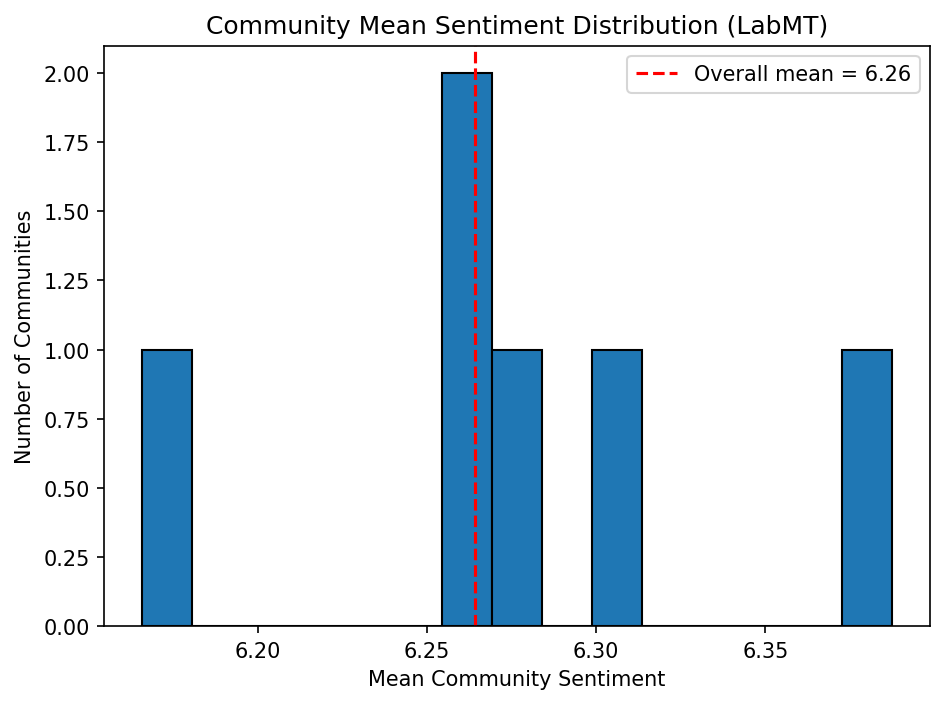

=== Top 10 Communities by Mean Sentiment ===
 community_id                                                      name  size  mean_sentiment  median_sentiment  variance      p25      p75
            3      Funkadelic, Parliament_(band), Parliament-Funkadelic     3        6.387551          6.401856  0.000969 6.376849 6.405405
            1                   Bob_Dylan, Eric_Clapton, Paul_McCartney   139        6.298957          6.301985  0.009510 6.235809 6.368209
            0                 Breaking_Benjamin, Nickelback, Papa_Roach    35        6.281206          6.295597  0.016610 6.227167 6.350366
            2                    Green_Day, Nirvana_(band), David_Bowie   116        6.263958          6.278871  0.017756 6.210560 6.348331
            5 Lynyrd_Skynyrd, Charlie_Daniels, The_Allman_Brothers_Band     7        6.259071          6.234344  0.028070 6.167521 6.334573
            4                     Metallica, Black_Sabbath, Deep_Purple    60        6.165737          6.210498  0.

In [29]:
# ===============================================================
# Exercise: Community Sentiment Distribution
# ===============================================================
# Goal:
#   Using the structural communities found last week (Louvain),
#   calculate community-level sentiment based on the LabMT scores
#   attached to each node. Analyze differences between communities
#   and the overall network sentiment.
#
# Files required:
#   - rock_performers_LWCC.gpickle     (graph with sentiment)
#   - community_labels.pickle          (Louvain community labels)
#   - page_sentiments.csv              (page-level sentiment)
#
# Output:
#   - Prints top 10 communities by sentiment
#   - Prints the 3 happiest and 3 saddest communities
#   - Compares to overall mean sentiment
#   - Displays histogram of community mean sentiments
# ===============================================================

import pickle
import numpy as np
import pandas as pd
import networkx as nx
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import os

# ---------- 1) Load graph and community data ----------
graph_path = "rock_performers_LWCC.gpickle"
comm_path = "community_labels.pickle"
sent_csv = "page_sentiments.csv"

assert os.path.exists(graph_path), f"Missing {graph_path}"
assert os.path.exists(comm_path), f"Missing {comm_path}"
assert os.path.exists(sent_csv), f"Missing {sent_csv}"

with open(graph_path, "rb") as f:
    H = pickle.load(f)

with open(comm_path, "rb") as f:
    data = pickle.load(f)
community_of = data["community_of"]
communities = data["communities"]

print(f"Loaded graph with {H.number_of_nodes()} nodes.")
print(f"Loaded {len(communities)} Louvain communities.")

# ---------- 2) Reattach sentiment if needed ----------
sent_df = pd.read_csv(sent_csv)

def normalize_name(name):
    return name.replace("_", " ").strip().lower()

sent_map = {normalize_name(r["artist"]): r["sentiment_labmt"] for _, r in sent_df.iterrows()}

attached = 0
for node in H.nodes():
    key = normalize_name(str(node))
    if key in sent_map:
        H.nodes[node]["sentiment_labmt"] = sent_map[key]
        attached += 1

print(f"✅ Sentiment attached to {attached} nodes.")

# ---------- 3) Compute sentiment per community ----------
community_sentiments = defaultdict(list)
for node, data in H.nodes(data=True):
    if "sentiment_labmt" in data and not np.isnan(data["sentiment_labmt"]):
        cid = community_of.get(node)
        if cid is not None:
            community_sentiments[cid].append(data["sentiment_labmt"])

print(f"Communities with sentiment data: {len(community_sentiments)}")

# ---------- 4) Aggregate statistics per community ----------
community_summary = []
for cid, svals in community_sentiments.items():
    if len(svals) == 0:
        continue
    mean_s = np.mean(svals)
    median_s = np.median(svals)
    var_s = np.var(svals, ddof=1) if len(svals) > 1 else 0.0
    q25, q75 = np.percentile(svals, [25, 75])
    community_summary.append({
        "community_id": cid,
        "size": len(svals),
        "mean_sentiment": mean_s,
        "median_sentiment": median_s,
        "variance": var_s,
        "p25": q25,
        "p75": q75
    })

summary_df = pd.DataFrame(community_summary).sort_values("mean_sentiment", ascending=False).reset_index(drop=True)

# ---------- 5) Name each community by its 3 most connected bands ----------
def top_3_connected_nodes(G, community_nodes):
    sub = G.subgraph(community_nodes)
    deg = dict(sub.degree())
    return [n for n, _ in sorted(deg.items(), key=lambda x: x[1], reverse=True)[:3]]

community_names = {}
for cid, nodes in enumerate(communities):
    top3 = top_3_connected_nodes(H, nodes)
    community_names[cid] = ", ".join(top3)

summary_df["name"] = summary_df["community_id"].map(community_names)
summary_df = summary_df[["community_id", "name", "size", "mean_sentiment", "median_sentiment", "variance", "p25", "p75"]]

# ---------- 6) Identify happiest & saddest communities ----------
happiest = summary_df.nlargest(3, "mean_sentiment")
saddest = summary_df.nsmallest(3, "mean_sentiment")

# ---------- 7) Compare to overall network sentiment ----------
sentiments = [d.get("sentiment_labmt") for _, d in H.nodes(data=True)]
sentiments = [s for s in sentiments if s is not None]
overall_mean = np.nanmean(sentiments)
diff_happy = happiest["mean_sentiment"].mean() - overall_mean
diff_sad = saddest["mean_sentiment"].mean() - overall_mean

# ---------- 8) Plot histogram ----------
plt.figure(dpi=150)
plt.hist(summary_df["mean_sentiment"].dropna(), bins=15, edgecolor="black")
plt.axvline(overall_mean, color="red", linestyle="--", label=f"Overall mean = {overall_mean:.2f}")
plt.title("Community Mean Sentiment Distribution (LabMT)")
plt.xlabel("Mean Community Sentiment")
plt.ylabel("Number of Communities")
plt.legend()
plt.tight_layout()
plt.show()

# ---------- 9) Results ----------
print("=== Top 10 Communities by Mean Sentiment ===")
print(summary_df.head(10).to_string(index=False))

print("\n=== Three Happiest Communities ===")
print(happiest[["community_id", "name", "mean_sentiment"]].to_string(index=False))

print("\n=== Three Saddest Communities ===")
print(saddest[["community_id", "name", "mean_sentiment"]].to_string(index=False))

print(f"\nOverall mean sentiment across all pages: {overall_mean:.3f}")
print(f"Average deviation (happiest - overall): +{diff_happy:.3f}")
print(f"Average deviation (saddest - overall): {diff_sad:.3f}")

# Optional: save results
summary_df.to_csv("community_sentiments.csv", index=False)
print("\n✅ Saved community sentiment summary to community_sentiments.csv")
